In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import time
import imageio
import cv2
import PIL
from carvekit.api.high import HiInterface

In [2]:
def pil_rectangle_crop(im):
    width, height = im.size   # Get dimensions
    
    if width <= height:
        left = 0
        right = width
        top = (height - width)/2
        bottom = (height + width)/2
    else:
        
        top = 0
        bottom = height
        left = (width - height) / 2
        bottom = (width + height) / 2

    # Crop the center of the image
    im = im.crop((left, top, right, bottom))
    return im

def add_margin(pil_img, color, size=256):
    width, height = pil_img.size
    result = Image.new(pil_img.mode, (size, size), color)
    result.paste(pil_img, ((size - width) // 2, (size - height) // 2))
    return result

def load_and_preprocess(image):
    '''
    :param seen_rgb (H, W, 3) tensor in [0, 1].
    :return est_seg (H, W) array in [0, 255].
    '''
    start_time = time.time()
    # See https://github.com/Ir1d/image-background-remove-tool

    # Check doc strings for more informationz
    interface = HiInterface(object_type="object",  # Can be "object" or "hairs-like".
                            batch_size_seg=5,
                            batch_size_matting=1,
                            device='cuda' if torch.cuda.is_available() else 'cpu',
                            seg_mask_size=640,  # Use 640 for Tracer B7 and 320 for U2Net
                            matting_mask_size=2048,
                            trimap_prob_threshold=231,
                            trimap_dilation=30,
                            trimap_erosion_iters=5,
                            fp16=False)

    # images_without_background = interface([args.image])
    image = image.convert('RGB')
#     image.thumbnail([1024, 1024], Image.Resampling.LANCZOS) 

    image_without_background = interface([image])[0]
    image_without_background = np.array(image_without_background)
    est_seg = image_without_background > 127
    image = np.array(image)
    foreground = est_seg[:, : , -1].astype(np.bool_)
    image[~foreground] = [255., 255., 255.]
    x, y, w, h = cv2.boundingRect(foreground.astype(np.uint8))
    image = image[y:y+h, x:x+w, :]
    image = PIL.Image.fromarray(np.array(image))
    
    image.thumbnail([200, 200], Image.Resampling.LANCZOS)# resize image such that long edge is 512
    image = add_margin(image, (255, 255, 255), size=256)
    image = np.array(image)
    
    print(f'Infer mask took {time.time() - start_time:.3f}s.')
    return image

In [24]:
root_path = '/home/rliu/Desktop/sculptures'
# img_path = os.path.join(root_path, 'pngwing.com.png')
img_path = os.path.join(root_path, os.listdir(root_path)[0])

Infer mask took 5.446s.


(256, 256, 3)

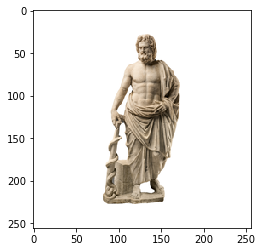

In [25]:
image = PIL.Image.open(img_path)
image = load_and_preprocess(image)
plt.imshow(image)
image.shape

In [26]:
for i_img, img_name in enumerate(os.listdir(root_path)):
    img_path = os.path.join(root_path, img_name)
    image = PIL.Image.open(img_path)
    image = load_and_preprocess(image)
    imageio.imwrite(os.path.join(root_path, '%d.png' % i_img), image)
    image.shape

Infer mask took 5.590s.
Infer mask took 1.309s.
Infer mask took 1.563s.
Infer mask took 1.330s.
Infer mask took 1.396s.
Infer mask took 1.281s.
Infer mask took 1.780s.
Infer mask took 2.173s.
Infer mask took 1.314s.
Infer mask took 1.321s.
